# Automatic Differentiation

Automatic differentiation takes a computational graph and produces another computational graph that computes the derivatives of the original graph.  The derivatives are computed using the chain rule.

## Computational graphs

So, let's start with computational graphs.
A computational graph is a directed acyclic graph (or DAG) that encodes the computation of a multivariate function.
We are going to use two types of nodes in the graph.
Tensor nodes (i.e., numerical arrays) are represented by circles.
Operation nodes (i.e., mathematical operations) are represented by squares.
The mathematical operators we consider here are *primitive* operators, i.e., operators that cannot be decomposed into simpler operations.
What are the primitive operators depends on where we are building the computational graph.
For example, if we are working directly at the level of the compiler of a programming language, the primitives are just the basic arithmetic operations (e.g., addition, multiplication).
But we can also work at a higher level, where the primitives are more complex operations (e.g., matrix multiplication, trigonometric functions, exponentials, power functions, and so on).
Because we are working within Python, we will use the second approach.
This is how `PyTorch` and `Jax` work.

Here is an example. Consider the following function:

$$
f(x) = x^2 + x
$$

Here is a good implementation of this function in Python:

```python
def f(x):
    a = x ** 2
    b = a + x
    return b
```

Notice how the implementation is reusing the intermediate results `a` and `b`.
Now, when packages like `PyTorch` and `Jax` see a call to this function with `x` being a tensor,they will build a computational graph that looks like this:

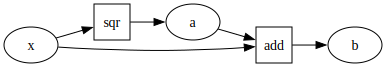

In [119]:
import graphviz

g = graphviz.Digraph(graph_attr={'size': '8,4'})
g.attr(rankdir='LR')

g.node('x')
g.node('a')
g.node('b')
g.node('sqr', shape='square')
g.node('add', shape='square')

g.edge('x', 'sqr')
g.edge('sqr', 'a')
g.edge('a', 'add')
g.edge('x', 'add')
g.edge('add', 'b')

g

Notice the directed edges from tensors to operators and from operators to tensors.
Notice that the graph has no cycles.
The squares are the primitive operators.
By primitive, we mean that they cannot be decomposed into simpler operations.
In a programming language, the primitives are the basic arithmetic operations (e.g., addition, multiplication).
In `PyTorch` and `Jax`, the primitives are more complex operations (e.g., matrix multiplication, trigonometric functions, exponentials, power functions, and so on).

Now if you ask `PyTorch` or `Jax` to compute the derivative of `c = f(x)` with respect to `x`, they will build a new computational graph that computes derivatives.

## Computing Jacobians is not a good idea

We start with a simple example of a chain composed of four primitive functions.
Generic DAGs are discussed later.
Suppose we compose four primitive functions, $f_1$, $f_2$, $f_3$, and $f_4$, to obtain a function $f$:

$$
f(x) = f_4(f_3(f_2(f_1(x)))).
$$

To be concrete, let's also add the input and output spaces for these functions:

$$
f_1: \mathbb{R}^n \rightarrow \mathbb{R}^p, \\
f_2: \mathbb{R}^p \rightarrow \mathbb{R}^q, \\
f_3: \mathbb{R}^q \rightarrow \mathbb{R}^r, \\
f_4: \mathbb{R}^r \rightarrow \mathbb{R}^m,
$$

so that

$$
f: \mathbb{R}^n \rightarrow \mathbb{R}^m.
$$

Using functional notation, we can write $f$ as the composition of the four functions:

$$
f = f_4 \circ f_3 \circ f_2 \circ f_1.
$$

Recall the chain rule from calculus.
Let's demonstrate it on $f_2\circ f_1$:

$$
\partial_j (f_2 \circ f_1)_i(x) = \sum_{k=1}^p \partial_k f_{2,i}(f_1(x)) \partial_j f_{1,k}(x) = \partial_k f_{2,i}(f_1(x)) \partial_j f_{1,k}(x),
$$

where in the last step we used the Einstein summation convention.
We can write this in matrix form as

$$
\nabla (f_2 \circ f_1)(x) = \nabla f_2(f_1(x)) \nabla f_1(x).
$$

In other words, the Jacobian of $f_2\circ f_1$ is a $q\times n$ matrix, and it is the product of the Jacobian of $f_2$ and the Jacobian of $f_1$.
Let's now add the rest of the functions:

$$
\nabla (f_4 \circ f_3 \circ f_2 \circ f_1)(x) = \nabla f_4(f_3(f_2(f_1(x)))) \nabla f_3(f_2(f_1(x))) \nabla f_2(f_1(x)) \nabla f_1(x).
$$

Okay, very good.
Let's introduce the code that computes this function:

```python
def f(x):
    a = f1(x)
    b = f2(a)
    c = f3(b)
    d = f4(c)
    return d
```

So, we now have names for the intermediate variables:

$$
a = f_1(x), \\
b = f_2(a), \\
c = f_3(b), \\
d = f_4(c).
$$

The computational graph is pretty simple:

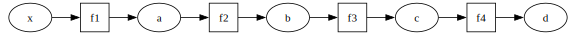

In [110]:
g = graphviz.Digraph(graph_attr={'size': '8,4'})
g.attr(rankdir='LR')

g.node('x')
g.node('a')
g.node('b')
g.node('c')
g.node('d')
g.node('f1', shape='square')
g.node('f2', shape='square')
g.node('f3', shape='square')
g.node('f4', shape='square')

g.edge('x', 'f1')
g.edge('f1', 'a')
g.edge('a', 'f2')
g.edge('f2', 'b')
g.edge('b', 'f3')
g.edge('f3', 'c')
g.edge('c', 'f4')
g.edge('f4', 'd')

g

We can rewrite the chain rule in terms of the intermediate variables:

$$
\nabla f(x) = \nabla f_4(c) \nabla f_3(b) \nabla f_2(a) \nabla f_1(x).
$$

Now, it looks a bit easier to understand what is going on.
So, the Jacobian we are after is the product of the Jacobians of the primitive functions.
This leads us to a very simple algorithm for computing the Jacobian of a function:

+ Run the computational graph forward to compute the intermediate variables.
+ Compute the Jacobian of each primitive function.
+ Then take the product of the Jacobians.

Okay. Multiplying Jacobians is easy. But it is a very bad idea. The Jacobians can be really really big in machine learning applications. Think millions by millions. They won't fit in memory. So, we need a better idea.

## Forward mode automatic differentiation or Jacobian-vector products

Let's give up on getting the full Jacobian.
We will compute products of a vector with the Jacobian.
There are two extreme possibilities: either we multiply the vector from the left or from the right.
From the right, we get the so called *Jacobian-vector product*:

$$
\nabla f(x) u = \Bigg(\nabla f_4(c) \bigg(\nabla f_3(b) \Big(\nabla f_2(a) \big(\nabla f_1(x) u\big)\Big)\bigg)\Bigg).
$$

We can do this calculation without forming the Jacobian.
We just need to know how to compute the Jacobian-vector product for each primitive function.
Let's say that each primitive has the Jacobian-vector product inside it and that we can access it by doing `primitive.jvp(x, u)`.
Then we can compute the Jacobian-vector product of the whole function by running the computational graph forward and applying the Jacobian-vector products of the primitives:

```python
a = f1(x)
v1 = f1.jvp(x, v)
b = f2(a)
v2 = f2.jvp(a, v1)
c = f3(b)
v3 = f3.jvp(b, v2)
d = f4(c)
pfv = f4.jvp(c, u3)
```

In terms of the computational graph, we are doing this:

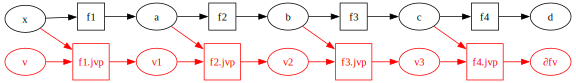

In [111]:
gf = g.copy()

gf.node('v', color='red', fontcolor='red')
gf.node('v1', color='red', fontcolor='red')
gf.node('v2', color='red', fontcolor='red')
gf.node('v3', color='red', fontcolor='red')
gf.node('dfv', label='&part;fv', color='red', fontcolor='red')
gf.node('f1.jvp', color='red', fontcolor='red', shape='square')
gf.node('f2.jvp', color='red', fontcolor='red', shape='square')
gf.node('f3.jvp', color='red', fontcolor='red', shape='square')
gf.node('f4.jvp', color='red', fontcolor='red', shape='square')

gf.edge('x', 'f1.jvp', color='red')
gf.edge('v', 'f1.jvp', color='red')
gf.edge('f1.jvp', 'v1', color='red')
gf.edge('a', 'f2.jvp', color='red')
gf.edge('v1', 'f2.jvp', color='red')
gf.edge('f2.jvp', 'v2', color='red')
gf.edge('b', 'f3.jvp', color='red')
gf.edge('v2', 'f3.jvp', color='red')
gf.edge('f3.jvp', 'v3', color='red')
gf.edge('c', 'f4.jvp', color='red')
gf.edge('v3', 'f4.jvp', color='red')
gf.edge('f4.jvp', 'dfv', color='red')

gf

This is straightforward. It is called the forward mode of automatic differentiation.
The benefits are that not much extra memory is required to carry it out.

How can we use it to get a specific component of the Jacobian?
Pick $v$ to be the unit vector $e_j$.
Then:

$$
\nabla f(x)e_j = \partial_k f(x) e_{jk} = \partial_j f(x).
$$

So, this picks the $j$-th column of the Jacobian.
We can get the entire Jacobian if we do this for $j=1,\ldots,n$.
In machine learning applications, typically $n$ is big and $m$ is small, e.g., if $f$ is a loss function, $n$ is the number of parameters and $m$ is one.
So, we would need $n$ passes to get the gradient of the loss with the forward mode.
This is as expensive as numerical differentiation.
We can do better.


## Reverse mode automatic differentiation or vector-Jacobian products

Let's try the other extreme.
Let's multiply the vector from the left.
This gives us the so called *vector-Jacobian product*.
Take $u$ in $\mathbb{R}^m$.
Then:

$$
u^T \nabla f(x) = \Big(\big((u^T\nabla f_4(c))\nabla f_3(b)\big)\nabla f_2(a)\Big)\nabla f_1(x).
$$

Suppose that the primitives know how to do the vector-Jacobian product.
Then we can do:

```python
# Forward pass
a = f1(x)
b = f2(a)
c = f3(b)
d = f4(c)

# Backward pass
u1 = f4.vjp(c, u)
u2 = f3.vjp(b, u1)
u3 = f2.vjp(a, u2)
uTpf = f1.vjp(x, u3)
```

In terms of the computational graph, it is like this:

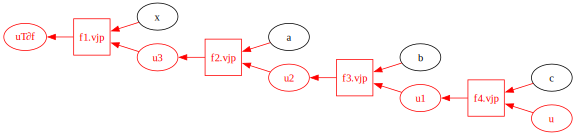

In [117]:
gb = graphviz.Digraph(graph_attr={'size': '8,4'})
gb.attr(rankdir='RL')

gb.node('x')
gb.node('a')
gb.node('b')
gb.node('c')

gb.node('u', color='red', fontcolor='red')
gb.node('u1', color='red', fontcolor='red')
gb.node('u2', color='red', fontcolor='red')
gb.node('u3', color='red', fontcolor='red')

gb.node('dfu', label='<u<sup>T</sup>&part;f>', color='red', fontcolor='red')

gb.node('f4.vjp', color='red', fontcolor='red', shape='square')
gb.node('f3.vjp', color='red', fontcolor='red', shape='square')
gb.node('f2.vjp', color='red', fontcolor='red', shape='square')
gb.node('f1.vjp', color='red', fontcolor='red', shape='square')

gb.edge('c', 'f4.vjp', color='red')
gb.edge('u', 'f4.vjp', color='red')
gb.edge('f4.vjp', 'u1', color='red')
gb.edge('b', 'f3.vjp', color='red')
gb.edge('u1', 'f3.vjp', color='red')
gb.edge('f3.vjp', 'u2', color='red')
gb.edge('a', 'f2.vjp', color='red')
gb.edge('u2', 'f2.vjp', color='red')
gb.edge('f2.vjp', 'u3', color='red')
gb.edge('x', 'f1.vjp', color='red')
gb.edge('u3', 'f1.vjp', color='red')
gb.edge('f1.vjp', 'dfu', color='red')

gb


That wasn't so bad either. Bad we need to store all the intermediate variables. And we need to run the graph forward and backward.
Again if we need the entire Jacobian, we pick $u = e_i$, the unit vector of $\mathbb{R}^m$ and we go from $i=1,\ldots,m$.
But now, for a classical machine learning application where $n$ is big and $m$ is small, we only need to do $m$ passes.
In particular, if $f$ is the loss, we only need to do one pass!
In this context, this algorithm is called *backpropagation*.

## Generic computational graphs

We would like to extend this to generic computational graphs.
Let's work with a simple example:

$$
f(x) = x + x,
$$

with code implementation:

```python
def f(x):
    a = x + x
    return a
```

What exactly is happening here?
The primitive `add` (i.e., `+`) acts on two tensors and produces a new tensor.
But here it acts on the same tensor twice.
So, there is some kind of other function that takes a tensor and produces two replicas of it.
Let's call this function `fanout`.
It is a function from $\mathbb{R}^n$ to $\mathbb{R}^{2n}$.
We can write the function `f` as:

$$
f = \text{add} \circ \text{fanout}.
$$

The Jacobian of `fanout` is a $2n\times n$ matrix:

$$
\nabla \text{fanout}(x) = \begin{bmatrix} I_n \\ I_n \end{bmatrix}.
$$

So, the required products are trivial.

Now that we wrote this function like that, there is no problem with the forward mode or the backward mode. It is just a chain.

Let's try a more complicated example:

$$
f(x) = x^2 + x,
$$

implemented as:

```python
def f(x):
    a = x * x
    b = a + x
    return b
```

First we have a square. The we add the square to `x`.
We can write this as:

$$
f = \text{add} \circ (\text{sqr}, \text{id}) \circ \text{fanout}.
$$

Here `id` is just the identity function (which has an identity Jacobian).
And by `(sqr, id)` we mean the function that takes a tensor $x$ and produces the pair $(x^2, x)$.
So, again we have a chain.

So on and so forth. This extends to any DAG.

## Where do I learn more?

The best think to do is to go over the implementation of automatic differentiation in [Autodidact (A pedagogical implementation of Autograd)](https://github.com/mattjj/autodidact) by Matt Johnson.
This is simple implementation of what is happening in `PyTorch` and `Jax`.